In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
import matplotlib.pyplot as plt
import os
from collections import Counter, defaultdict

In [17]:
data_folder = 'src/'


containers = list(map(lambda name: name.split('.csv')[0], os.listdir(data_folder)))
trains = []
data: dict[str: pd.DataFrame] = {}

for cont_name in containers:
    data[cont_name] = pd.read_csv(data_folder + cont_name + '.csv')
    trains.append(list(range(len(data[cont_name]['номер поезда']))))

In [ ]:
class AssetsProblem(ElementwiseProblem):
    RANDOM_SEED = 1210
    def __init__(self, data: pd.DataFrame, containers):
        super().__init__(n_var=len(data), n_obj=4, xl=0, xu=len(list(data.values())[0])-1, vtype=int)
        self.X = data
        self.priority_arrays = {k: v.iloc[:, 1].values for k, v in data.items()}
        self.container_weights = np.array([int(c[6:]) for c in containers])
        self.containers = containers
        self.container_types = [c[4:-5] for c in self.containers]

    def get_priorities(self, x):
        priorities = np.array([self.priority_arrays[cont_name][x[i]] for i, cont_name in enumerate(containers)])
        return priorities.sum()  # + (priorities >= 10).sum() * 1000

    
    def get_m(self, arr):
        counts = np.bincount(arr)
        return counts.max() - counts.min()

    
    def get_weight_diff(self, arr):
        from collections import defaultdict
        weights = defaultdict(int)
        for train, weight in zip(arr, self.container_weights):
            weights[train] += weight

        weight_values = np.array(list(weights.values()))
        return weight_values.max() - weight_values.min()
    
    def get_type_score(self, arr):
        trains = defaultdict(list)
        for train, cont_type in zip(arr, self.container_types):
            trains[train].append(cont_type)

        scores = []
        for cont_types in trains.values():
            counter = Counter(cont_types)
            _, best_count = counter.most_common(1)[0]
            score = best_count / len(cont_types)
            scores.append(score)

        return -np.mean(scores)

    def _evaluate(self, x: np.ndarray, out: dict, *args, **kwargs) -> None:

        priority_sum = self.get_priorities(x)
        m_diff = self.get_m(x)
        weight_diff = self.get_weight_diff(x)
        type_score = self.get_type_score(x)

        out['F'] = [priority_sum, m_diff, weight_diff, type_score]

In [ ]:
import numpy as np
from pymoo.core.sampling import Sampling

class CustomCategoricalSampling(Sampling):
    def __init__(self, values_list, probs_list=None):
        super().__init__()
        self.values_list = values_list
        self.probs_list = probs_list
        
        if probs_list is not None and len(probs_list) != len(values_list):
            raise ValueError("probs_list and values_list must have the same length")

        if probs_list is not None:
            for p in probs_list:
                if not np.isclose(sum(p), 1):
                    raise ValueError("Probabilities for each variable must sum to 1")

    def _do(self, problem, n_samples, **kwargs):
        n_var = problem.n_var
        samples = np.empty((n_samples, n_var), dtype=int)
        
        for var_idx in range(n_var):
            values = self.values_list[var_idx]
            samples[:, var_idx] = np.random.choice(values, size=n_samples)
        return samples




In [24]:
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.repair.rounding import RoundingRepair

algorithm = NSGA2(
    pop_size=1000,
    sampling=CustomCategoricalSampling(values_list=trains),
    crossover=SBX(prob=0.9, repair=RoundingRepair()),
    mutation=PM(prob=0.1, repair=RoundingRepair()),
    eliminate_duplicates=True
)

In [25]:
problem = AssetsProblem(data, containers)

res = minimize(problem,
    algorithm,
    ('n_gen', 100),
    verbose=False
)


In [26]:
len(containers)

500

In [38]:
from sklearn.preprocessing import MinMaxScaler

F = res.F
X = res.X

scaler = MinMaxScaler()

F_norm = scaler.fit_transform(F)

weights = np.array([0.1, 1, 0.1, 0.1])

weighted_sums = np.dot(F_norm, weights)

best_idx = np.argmin(weighted_sums)

best_solution = X[best_idx]
best_metrics = F[best_idx]

print("Лучшее решение:", best_solution)
print("Значения метрик:", best_metrics)
print("Взвешенная сумма метрик:", weighted_sums[best_idx])


Лучшее решение: [41 45 12 38 18  6  4 38 34 43 31  7 16 15 33 18 24 23 15 14  8 34 10 17
 28 22 24  5  0 12 31  6  0  9  4 27 30 10 30 38 12  6 11 35 15  1 39 38
 16 21 23 42 15 10 30 44  8 16 47 36 29 12 19 45  1 34 25  2 36 44 21 25
  3 46  8 40  4  9 14  5 29  7 44 17 43 26 36 47 20 35 27 26 16 13 24 47
 29 29 39 27 28 46 28  3 13 37 15  2  5 21  2  3 21 11  8  3 12  9 36 21
 44 31 30  5  6 22  6  2 12 43 45 10 46  9 46  6 25 32 40 43 36 47 30 12
 25 41 19 33  5 22 19 40 46 21 41 26  1 14 22 17 40 43 13 32 31  8 12 25
 41 36  7  4 35 30  0 44 39 19 15 22 39 40 25 40 19  1 39 23 10 11 38 28
 45 26 15 24 19 22 42  2 31 16 47 17 35 43 26 46  9 38 37  5  8 45 47  0
 35 15 16 26 44 42 28 28 18  0 42 32 17 40 17 37 41 19  9  5 19 38  2 11
 33 41 23 36 24  0 27 47  3 47 17 34 39 48 16 25 31 30  3  0  1 14  4 24
 37 37 33 40 23 26 11  3 28 40 10 37  8 20 27 30 25 45 44 48 32 22  7 39
 48 17  0 48 35 42 34 39 18  1  1 22 11 17 41 25  4 25  4 27 47  6 43 14
 34 10 44 18 39 20 12 32 34 11 41 1

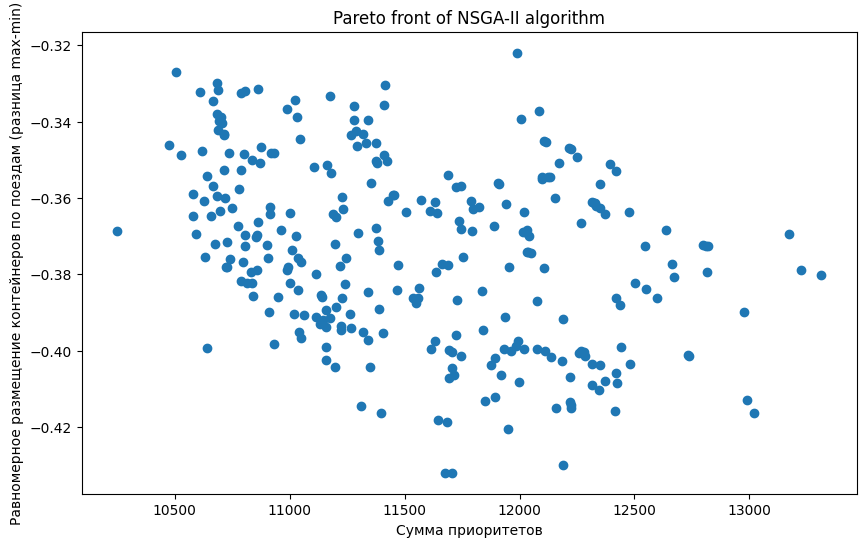

In [ ]:
# Визуализируем результаты

plt.figure(figsize=(10, 6))
plt.scatter(res.F[:, 0], res.F[:, 1])
plt.xlabel("Сумма приоритетов")
plt.ylabel("Равномерное размещение контейнеров по поездам (разница max-min)")
plt.title("Pareto front of NSGA-II algorithm")
plt.show()

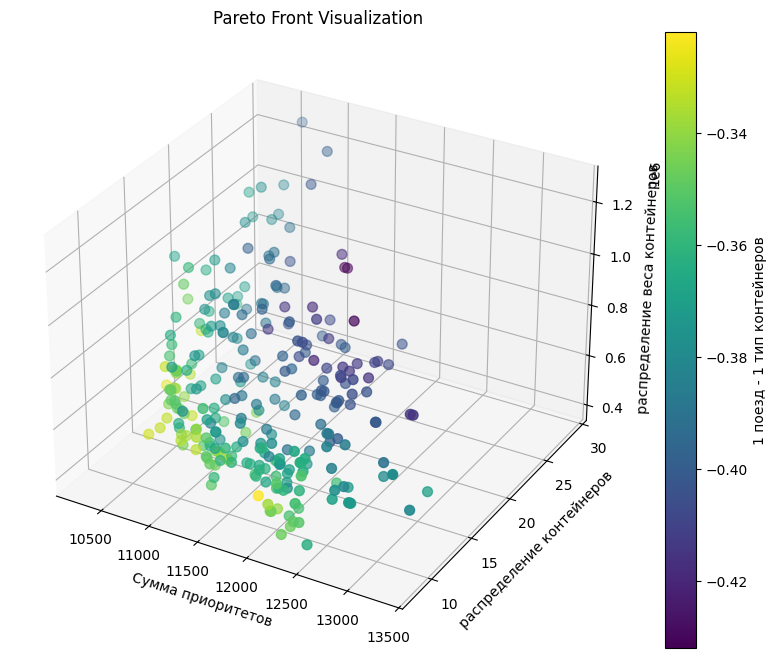

In [ ]:
objectives = res.F

def is_pareto_efficient(costs):
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1)
            is_efficient[i] = True
    return is_efficient

pareto_mask = is_pareto_efficient(objectives)
pareto_points = objectives[pareto_mask]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x = pareto_points[:, 0]
y = pareto_points[:, 1]
z = pareto_points[:, 2]
c = pareto_points[:, 3]

sc = ax.scatter(x, y, z, c=c, cmap='viridis', s=50)
ax.set_xlabel('Сумма приоритетов')
ax.set_ylabel('распределение контейнеров')
ax.set_zlabel('распределение веса контейнеров')
plt.colorbar(sc, label='средний % преобл-го типа конт-ов по поездам')
plt.title('Парето фронт')
plt.show()


In [33]:
import numpy as np
import plotly.graph_objects as go
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

objectives = res.F
nds = NonDominatedSorting()
is_efficient = nds.do(objectives)
pareto_points = objectives[is_efficient]

pareto_points = np.array(pareto_points).squeeze()

fig = go.Figure(data=[go.Scatter3d(
    x=pareto_points[:, 0],
    y=pareto_points[:, 1],
    z=pareto_points[:, 2],
    mode='markers',
    marker=dict(
        size=8,
        color=pareto_points[:, 3].__abs__(),
        colorscale='Viridis',
        opacity=0.8,
        colorbar=dict(title='средний % преобл-го типа конт-ов по поездам')
    ),
    text=[
        f'Objective 1: {obj[0].item():.2f}<br>'
        f'Objective 2: {obj[1].item():.2f}<br>'
        f'Objective 3: {obj[2].item():.2f}<br>'
        f'Objective 4: {obj[3].item():.2f}'
        for obj in pareto_points
    ]
)])

fig.update_layout(
    scene=dict(
        xaxis_title='Сумма приоритетов',
        yaxis_title='распределение контейнеров',
        zaxis_title='распределение веса контейнеров'
    ),
    title='Парето фронт'
)

fig.show()
